In [1]:
import os
import random
import shutil
from pathlib import Path
from collections import defaultdict
from PIL import Image
import numpy as np
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
# Mount Google Drive & unzip dataset (jika zip di Drive)
from google.colab import drive
drive.mount('/content/drive')

# Ubah path sesuai lokasi zip di Drive
ZIP_PATH = '/content/drive/MyDrive/dataset_selada.zip'   # <- ganti jika beda
WORK_DIR = Path('/content')
EXTRACT_DIR = WORK_DIR / 'dataset_selada'   # hasil unzip

if not EXTRACT_DIR.exists():
    print("Unzipping", ZIP_PATH, "->", EXTRACT_DIR)
    import zipfile
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(WORK_DIR)
else:
    print("Dataset already unzipped at", EXTRACT_DIR)

# Pastikan struktur: dataset_selada/dataset_selada/plant-condition/{normal,stres}
DATA_ROOT = EXTRACT_DIR / 'plant-condition'
print("Expected data root:", DATA_ROOT)
print("Exists?", DATA_ROOT.exists())
print("Classes:", [p.name for p in DATA_ROOT.iterdir() if p.is_dir()])

Mounted at /content/drive
Unzipping /content/drive/MyDrive/dataset_selada.zip -> /content/dataset_selada
Expected data root: /content/dataset_selada/plant-condition
Exists? True
Classes: ['stres', 'normal']


In [3]:
#Split dataset into train/val/test (70/15/15), per-class
SRC_DIR = DATA_ROOT
OUT_DIR = Path('/content/dataset_split') # Output directory
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SEED = 42 # Untuk reproducibility
#Seed adalah nilai awal untuk generator angka acak
IMG_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.PNG'}

random.seed(SEED)

def list_images_by_class(src_dir): # Mengambil semua gambar dari setiap folder (kelas) yang berada langsung di dalam src_dir
    files = {}
    for p in sorted(src_dir.iterdir()): #Lihat semua isi folder
        if p.is_dir(): #Ambil hanya folder (kelas)
            imgs = [f for f in p.iterdir() if f.suffix.lower() in IMG_EXTS] #Ambil semua file gambar dalam folder
            files[p.name] = imgs #Simpan dalam dictionary
    return files

def split_and_copy(files_by_class, out_dir=OUT_DIR, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6 # memastikan total 100%
    out_dir.mkdir(parents=True, exist_ok=True)
    for split in ['train', 'val', 'test']: #struktur folder output
        for cls in files_by_class.keys():
            (out_dir / split / cls).mkdir(parents=True, exist_ok=True)
    for cls, files in files_by_class.items():
        files = list(files) #Ambil file tiap kelas
        random.shuffle(files) # Acak urutan file
        n = len(files)
        n_train = int(n * train_ratio) #Hitung jumlah untuk setiap set
        n_val = int(n * val_ratio)
        # Bagi file berdasarkan jumlah
        n_test = n - n_train - n_val
        train_files = files[:n_train]
        val_files = files[n_train:n_train + n_val]
        test_files = files[n_train + n_val:]
        for src in train_files:
            dst = out_dir / 'train' / cls / src.name
            if not dst.exists(): #Membawa file ke folder baru
                shutil.copy2(src, dst)
        for src in val_files:
            dst = out_dir / 'val' / cls / src.name
            if not dst.exists():
                shutil.copy2(src, dst)
        for src in test_files:
            dst = out_dir / 'test' / cls / src.name
            if not dst.exists():
                shutil.copy2(src, dst)
    return out_dir
#baca setiap folder kelas di dalam SRC_DIR & kumpulkan gambar per kelas
files_by_class = list_images_by_class(SRC_DIR)
print({k: len(v) for k, v in files_by_class.items()}) # mengecek berapa banyak gambar per kelas
out = split_and_copy(files_by_class) #untuk menjalankan proses pembagian
print("Split created at:", out)
# Mengecek pembagian berhasil
for split in ['train','val','test']: #loop ke semua folder (train/val/test)
    for cls in files_by_class.keys(): #loop ke semua kelas
        c = len(list((out/split/cls).glob('*'))) #hitung jumlah file di dalam folder itu
        print(f"{split}/{cls}: {c}")

{'normal': 326, 'stres': 326}
Split created at: /content/dataset_split
train/normal: 228
train/stres: 228
val/normal: 48
val/stres: 48
test/normal: 50
test/stres: 50


In [4]:
#Optional brightness analysis (helps keputusan augmentasi)
def compute_brightness(path):
    try:
        im = Image.open(path).convert('L') #Ubah ke grayscale
        return np.array(im).mean() #Hitung rata-rata semua piksel
    except:
        return None

for cls, files in files_by_class.items():
    br = [compute_brightness(p) for p in files]
    br = [b for b in br if b is not None]
    print(cls, "count", len(br), "mean-brightness", float(np.mean(br)), "std", float(np.std(br)))

normal count 326 mean-brightness 137.5134373429332 std 22.7438591399506
stres count 326 mean-brightness 143.77645953516068 std 31.138282218372073


In [5]:
#tf.data pipeline builder
from pathlib import Path

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def list_files_labels(base_dir):
    base_dir = Path(base_dir)
    classes = sorted([p.name for p in base_dir.iterdir() if p.is_dir()]) #Menemukan folder kelas
    filepaths = []
    labels = []
    for idx, cls in enumerate(classes): #memberi label numerik
        p = base_dir / cls
        for f in p.iterdir():
            if f.is_file():
                filepaths.append(str(f))
                labels.append(idx)
    return filepaths, labels, classes

def decode_and_resize(path, label):
    img = tf.io.read_file(path) #baca dari disk (byte)
    img = tf.image.decode_image(img, channels=3, expand_animations=False) #pastikan RGB
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE) #ubah ukuran
    # return float32 0..255 (we'll use model preprocess inside model)
    img = tf.cast(img, tf.float32) #angka piksel jadi float
    return img, label

def make_ds(split_dir, batch_size=BATCH_SIZE, shuffle=True):
    paths, labels, classes = list_files_labels(split_dir)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)
    ds = ds.map(lambda p, l: tf.py_function(func=decode_and_resize, inp=[p, l], Tout=[tf.float32, tf.int32]), #Load dan resize gambar
                num_parallel_calls=AUTOTUNE)
    # set shapes
    def set_shapes(img, lbl):
        img.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
        lbl.set_shape([])
        return img, lbl
    ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds, classes

# Example use:
train_ds, CLASS_NAMES = make_ds(out / 'train')
val_ds, _ = make_ds(out / 'val', shuffle=False)
test_ds, _ = make_ds(out / 'test', shuffle=False)
print("Classes:", CLASS_NAMES)
print("Train batches:", len(list(train_ds)))

Classes: ['normal', 'stres']
Train batches: 15


In [6]:
#Augmentation layer (tf.keras)
def get_augmentation():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.RandomRotation(0.12), #Rotasi acak 12%
        tf.keras.layers.RandomZoom(0.12), #zoom acak 12%
        tf.keras.layers.RandomTranslation(0.06, 0.06), #Geser gambar secara acak hingga 6%
        tf.keras.layers.RandomContrast(0.12), #Ubah kontras gambar 12%
    ], name='augmentation')

In [ ]:
# Build model (EfficientNetB0)
def build_model(img_size=IMG_SIZE, dropout=0.4):
    # Define input layer dengan shape sesuai ukuran gambar
    inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3))

    # Dapatkan augmentation layer untuk data preprocessing
    aug = get_augmentation()

    # Terapkan augmentation pada input gambar
    x = aug(inputs)                         # augmentation in-graph

    # Preprocessing untuk EfficientNetB0 - mengubah skala piksel ke format yang diharapkan
    # Fungsi ini akan mengubah skala piksel ke format standar EfficientNet (sekitar -1 s/d +1)
    x = tf.keras.applications.efficientnet.preprocess_input(x)

    # Load model EfficientNetB0 pre-trained dari ImageNet
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,      # Tidak include layer classifier (top layer)
        input_tensor=x,         # Gunakan tensor yang sudah dipreprocess sebagai input
        weights='imagenet'      # Gunakan weights yang sudah di-training di ImageNet
    )

    # Bekukan semua layer di base model (tidak akan di-training selama fase awal)
    base.trainable = False

    # Tambahkan custom classifier di atas base model
    # Global Average Pooling: mengurangi dimensi feature map menjadi vektor 1D
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)

    # Batch Normalization: menstabilkan dan mempercepat training
    x = tf.keras.layers.BatchNormalization()(x)

    # Dropout: mencegah overfitting dengan mematikan neuron secara acak
    x = tf.keras.layers.Dropout(dropout)(x)

    # Output layer dengan 1 neuron dan aktivasi sigmoid untuk klasifikasi biner
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Bangun model lengkap dengan menghubungkan input dan output
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Return model dan base model untuk keperluan fine-tuning nanti
    return model, base

# Build model dan dapatkan model serta base model-nya
model, base_model = build_model()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ augmentation[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,055,972 (15.47 MB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
#Training (head then fine-tune)
CHECKPOINT = '/content/best_model.h5'

# Phase 1: Head training (frozen backbone)
initial_epochs = 12 # Jumlah epoch untuk training head saja
fine_tune_epochs = 28 # Jumlah epoch untuk fine-tuning

# Compile model untuk training head
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy', # Fungsi loss untuk klasifikasi biner
              metrics=['accuracy']) # Metrik untuk evaluasi performa

# Callbacks untuk memantau dan mengontrol proses training
callbacks = [
     # Early stopping: hentikan training jika val_loss tidak membaik
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
     # Reduce LR: turunkan learning rate jika performa stagnan
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
     # Model checkpoint: simpan model terbaik
    tf.keras.callbacks.ModelCheckpoint(CHECKPOINT, monitor='val_loss', save_best_only=True, verbose=1)
]
# Fase 1: Training hanya pada head classifier (backbone dibekukan)
history1 = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds, callbacks=callbacks)

# Fase 2: Fine-tuning - buka sebagian layer backbone untuk training
base_model.trainable = True # Aktifkan training pada base model
# Tentukan layer mana yang akan di-unfreeze (40% layer terakhir)
fine_tune_at = int(len(base_model.layers) * 0.6) # 60% layer awal tetap frozen
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= fine_tune_at  # Hanya layer setelah index fine_tune_at yang di-training
# Compile ulang dengan learning rate lebih rendah untuk fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # LR lebih kecil untuk fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Lanjutkan training dengan fine-tuning
history2 = model.fit(train_ds, epochs=initial_epochs + fine_tune_epochs,
                     initial_epoch=history1.epoch[-1] + 1 if len(history1.history['loss'])>0 else 0,
                     # Lanjut dari epoch terakhir fase 1
                     validation_data=val_ds, callbacks=callbacks)

Epoch 1/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5854 - loss: 0.8264
Epoch 1: val_loss improved from inf to 0.63537, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 692ms/step - accuracy: 0.5855 - loss: 0.8251 - val_accuracy: 0.7083 - val_loss: 0.6354 - learning_rate: 1.0000e-04
Epoch 2/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.5937 - loss: 0.8972
Epoch 2: val_loss improved from 0.63537 to 0.61491, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 472ms/step - accuracy: 0.5949 - loss: 0.8922 - val_accuracy: 0.7812 - val_loss: 0.6149 - learning_rate: 1.0000e-04
Epoch 3/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.6651 - loss: 0.7042
Epoch 3: val_loss improved from 0.61491 to 0.59589, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 660ms/step - accuracy: 0.6652 - loss: 0.7036 - val_accuracy: 0.7917 - val_loss: 0.5959 - learning_rate: 1.0000e-04
Epoch 4/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.6633 - loss: 0.6743
Epoch 4: val_loss improved from 0.59589 to 0.58001, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 558ms/step - accuracy: 0.6635 - loss: 0.6744 - val_accuracy: 0.8021 - val_loss: 0.5800 - learning_rate: 1.0000e-04
Epoch 5/12
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.6757 - loss: 0.6716
Epoch 5: val_loss improved from 0.58001 to 0.56316, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 494ms/step - accuracy: 0.6743 - loss: 0.6743 - val_accuracy: 0.8125 - val_loss: 0.5632 - learning_rate: 1.0000e-04
Epoch 6/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6828 - loss: 0.6107
Epoch 6: val_loss improved from 0.56316 to 0.54803, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 484ms/step - accuracy: 0.6815 - loss: 0.6130 - val_accuracy: 0.8229 - val_loss: 0.5480 - learning_rate: 1.0000e-04
Epoch 7/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.7104 - loss: 0.5908
Epoch 7: val_loss improved from 0.54803 to 0.53275, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 572ms/step - accuracy: 0.7107 - loss: 0.5914 - val_accuracy: 0.8333 - val_loss: 0.5328 - learning_rate: 1.0000e-04
Epoch 8/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.6979 - loss: 0.6721
Epoch 8: val_loss improved from 0.53275 to 0.52201, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 516ms/step - accuracy: 0.6993 - loss: 0.6686 - val_accuracy: 0.8229 - val_loss: 0.5220 - learning_rate: 1.0000e-04
Epoch 9/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6790 - loss: 0.7013
Epoch 9: val_loss improved from 0.52201 to 0.50935, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step - accuracy: 0.6812 - loss: 0.6976 - val_accuracy: 0.8229 - val_loss: 0.5093 - learning_rate: 1.0000e-04
Epoch 10/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6740 - loss: 0.7051
Epoch 10: val_loss improved from 0.50935 to 0.49962, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 557ms/step - accuracy: 0.6757 - loss: 0.7012 - val_accuracy: 0.8229 - val_loss: 0.4996 - learning_rate: 1.0000e-04
Epoch 11/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.7229 - loss: 0.5867
Epoch 11: val_loss improved from 0.49962 to 0.48748, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step - accuracy: 0.7226 - loss: 0.5863 - val_accuracy: 0.8229 - val_loss: 0.4875 - learning_rate: 1.0000e-04
Epoch 12/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6871 - loss: 0.6447
Epoch 12: val_loss improved from 0.48748 to 0.47567, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.6893 - loss: 0.6416 - val_accuracy: 0.8333 - val_loss: 0.4757 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 12.
Epoch 13/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.6164 - loss: 0.7614
Epoch 13: val_loss improved from 0.47567 to 0.45909, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 797ms/step - accuracy: 0.6168 - loss: 0.7609 - val_accuracy: 0.8542 - val_loss: 0.4591 - learning_rate: 1.0000e-05
Epoch 14/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6113 - loss: 0.7492
Epoch 14: val_loss improved from 0.45909 to 0.44217, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 573ms/step - accuracy: 0.6120 - loss: 0.7489 - val_accuracy: 0.8542 - val_loss: 0.4422 - learning_rate: 1.0000e-05
Epoch 15/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.6759 - loss: 0.6667
Epoch 15: val_loss improved from 0.44217 to 0.42929, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 513ms/step - accuracy: 0.6771 - loss: 0.6636 - val_accuracy: 0.8333 - val_loss: 0.4293 - learning_rate: 1.0000e-05
Epoch 16/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.6866 - loss: 0.6380
Epoch 16: val_loss improved from 0.42929 to 0.42055, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 600ms/step - accuracy: 0.6863 - loss: 0.6380 - val_accuracy: 0.8333 - val_loss: 0.4206 - learning_rate: 1.0000e-05
Epoch 17/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7264 - loss: 0.6431
Epoch 17: val_loss improved from 0.42055 to 0.41787, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 591ms/step - accuracy: 0.7265 - loss: 0.6411 - val_accuracy: 0.8333 - val_loss: 0.4179 - learning_rate: 1.0000e-05
Epoch 18/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7147 - loss: 0.5908
Epoch 18: val_loss improved from 0.41787 to 0.41679, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 508ms/step - accuracy: 0.7136 - loss: 0.5912 - val_accuracy: 0.8125 - val_loss: 0.4168 - learning_rate: 1.0000e-05
Epoch 19/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7462 - loss: 0.5534
Epoch 19: val_loss improved from 0.41679 to 0.41263, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 519ms/step - accuracy: 0.7467 - loss: 0.5510 - val_accuracy: 0.8021 - val_loss: 0.4126 - learning_rate: 1.0000e-05
Epoch 20/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7758 - loss: 0.4951
Epoch 20: val_loss improved from 0.41263 to 0.40727, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 592ms/step - accuracy: 0.7750 - loss: 0.4959 - val_accuracy: 0.8229 - val_loss: 0.4073 - learning_rate: 1.0000e-05
Epoch 21/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7557 - loss: 0.4887
Epoch 21: val_loss improved from 0.40727 to 0.39875, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - accuracy: 0.7560 - loss: 0.4905 - val_accuracy: 0.8333 - val_loss: 0.3987 - learning_rate: 1.0000e-05
Epoch 22/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7966 - loss: 0.4537
Epoch 22: val_loss improved from 0.39875 to 0.39350, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 601ms/step - accuracy: 0.7960 - loss: 0.4553 - val_accuracy: 0.8333 - val_loss: 0.3935 - learning_rate: 1.0000e-05
Epoch 23/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7783 - loss: 0.4629
Epoch 23: val_loss improved from 0.39350 to 0.38113, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 537ms/step - accuracy: 0.7780 - loss: 0.4642 - val_accuracy: 0.8438 - val_loss: 0.3811 - learning_rate: 1.0000e-05
Epoch 24/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7643 - loss: 0.5131
Epoch 24: val_loss improved from 0.38113 to 0.36854, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 493ms/step - accuracy: 0.7656 - loss: 0.5114 - val_accuracy: 0.8438 - val_loss: 0.3685 - learning_rate: 1.0000e-05
Epoch 25/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8064 - loss: 0.4148
Epoch 25: val_loss improved from 0.36854 to 0.35490, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 585ms/step - accuracy: 0.8066 - loss: 0.4144 - val_accuracy: 0.8438 - val_loss: 0.3549 - learning_rate: 1.0000e-05
Epoch 26/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8239 - loss: 0.4429
Epoch 26: val_loss improved from 0.35490 to 0.34441, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 655ms/step - accuracy: 0.8238 - loss: 0.4416 - val_accuracy: 0.8542 - val_loss: 0.3444 - learning_rate: 1.0000e-05
Epoch 27/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8196 - loss: 0.3723
Epoch 27: val_loss improved from 0.34441 to 0.32889, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 489ms/step - accuracy: 0.8188 - loss: 0.3739 - val_accuracy: 0.8542 - val_loss: 0.3289 - learning_rate: 1.0000e-05
Epoch 28/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8678 - loss: 0.3316
Epoch 28: val_loss improved from 0.32889 to 0.31744, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step - accuracy: 0.8666 - loss: 0.3343 - val_accuracy: 0.8646 - val_loss: 0.3174 - learning_rate: 1.0000e-05
Epoch 29/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8371 - loss: 0.3817
Epoch 29: val_loss improved from 0.31744 to 0.30322, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 577ms/step - accuracy: 0.8355 - loss: 0.3830 - val_accuracy: 0.8646 - val_loss: 0.3032 - learning_rate: 1.0000e-05
Epoch 30/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8740 - loss: 0.3362
Epoch 30: val_loss improved from 0.30322 to 0.28988, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 575ms/step - accuracy: 0.8741 - loss: 0.3367 - val_accuracy: 0.8646 - val_loss: 0.2899 - learning_rate: 1.0000e-05
Epoch 31/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8494 - loss: 0.3614
Epoch 31: val_loss improved from 0.28988 to 0.28331, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 508ms/step - accuracy: 0.8497 - loss: 0.3611 - val_accuracy: 0.8750 - val_loss: 0.2833 - learning_rate: 1.0000e-05
Epoch 32/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8629 - loss: 0.3321
Epoch 32: val_loss improved from 0.28331 to 0.27477, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.8624 - loss: 0.3319 - val_accuracy: 0.8750 - val_loss: 0.2748 - learning_rate: 1.0000e-05
Epoch 33/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8110 - loss: 0.3951
Epoch 33: val_loss improved from 0.27477 to 0.26567, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 583ms/step - accuracy: 0.8124 - loss: 0.3928 - val_accuracy: 0.8750 - val_loss: 0.2657 - learning_rate: 1.0000e-05
Epoch 34/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8788 - loss: 0.3047
Epoch 34: val_loss improved from 0.26567 to 0.25786, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 509ms/step - accuracy: 0.8794 - loss: 0.3039 - val_accuracy: 0.8750 - val_loss: 0.2579 - learning_rate: 1.0000e-05
Epoch 35/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8248 - loss: 0.3344
Epoch 35: val_loss improved from 0.25786 to 0.25254, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 900ms/step - accuracy: 0.8257 - loss: 0.3341 - val_accuracy: 0.8750 - val_loss: 0.2525 - learning_rate: 1.0000e-05
Epoch 36/40
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8561 - loss: 0.3314
Epoch 36: val_loss improved from 0.25254 to 0.24152, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 892ms/step - accuracy: 0.8558 - loss: 0.3312 - val_accuracy: 0.8854 - val_loss: 0.2415 - learning_rate: 1.0000e-05
Epoch 37/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.8508 - loss: 0.2993
Epoch 37: val_loss improved from 0.24152 to 0.23528, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 874ms/step - accuracy: 0.8511 - loss: 0.2988 - val_accuracy: 0.8958 - val_loss: 0.2353 - learning_rate: 1.0000e-05
Epoch 38/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8863 - loss: 0.2791
Epoch 38: val_loss improved from 0.23528 to 0.23326, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 597ms/step - accuracy: 0.8863 - loss: 0.2799 - val_accuracy: 0.8958 - val_loss: 0.2333 - learning_rate: 1.0000e-05
Epoch 39/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8821 - loss: 0.2657
Epoch 39: val_loss improved from 0.23326 to 0.22755, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - accuracy: 0.8822 - loss: 0.2653 - val_accuracy: 0.8958 - val_loss: 0.2275 - learning_rate: 1.0000e-05
Epoch 40/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9156 - loss: 0.2121
Epoch 40: val_loss improved from 0.22755 to 0.21856, saving model to /content/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 601ms/step - accuracy: 0.9135 - loss: 0.2149 - val_accuracy: 0.8958 - val_loss: 0.2186 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 40.


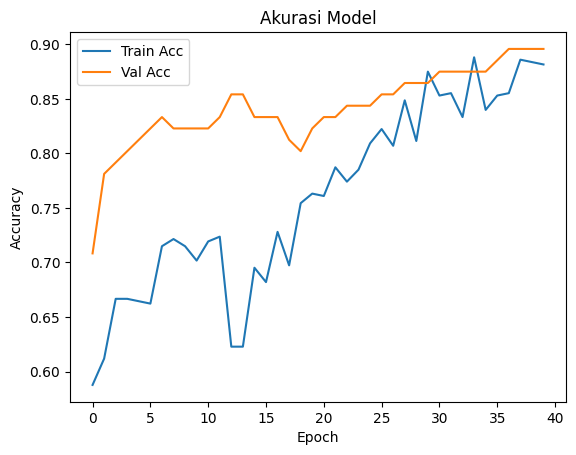

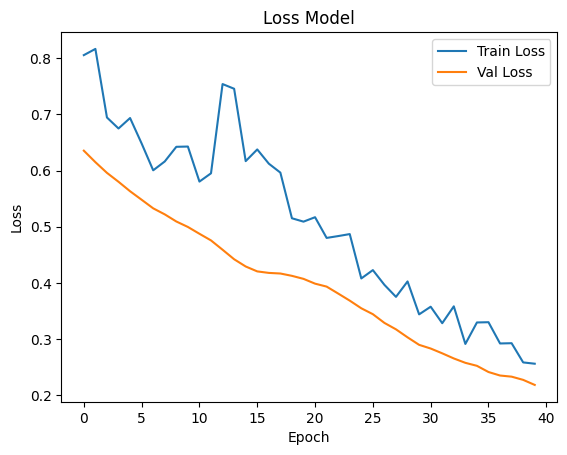

In [ ]:
import matplotlib.pyplot as plt

plt.plot(full_history['accuracy'], label='Train Acc')
plt.plot(full_history['val_accuracy'], label='Val Acc')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Val Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification report:
              precision    recall  f1-score   support

      normal       0.84      0.98      0.91        50
       stres       0.98      0.82      0.89        50

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100

Confusion matrix:
 [[49  1]
 [ 9 41]]


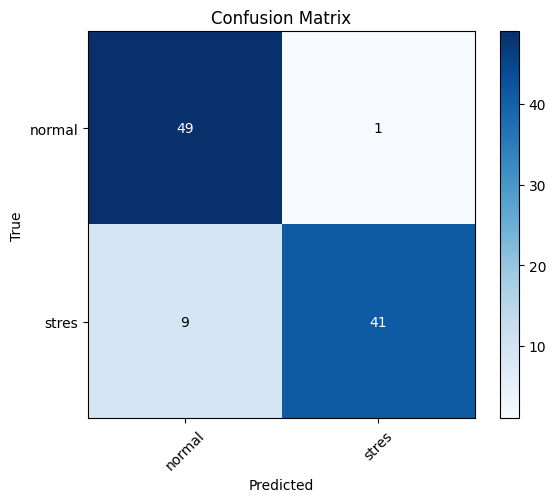

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf

# Load model
model = tf.keras.models.load_model(CHECKPOINT)

# Collect predictions
y_true = []
y_pred = []

for imgs, labels in test_ds:
    preds = model.predict(imgs)
    y_pred.extend((preds.flatten() >= 0.5).astype(int).tolist())
    y_true.extend(labels.numpy().tolist())

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# HEATMAP CONFUSION MATRIX
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES, rotation=45)
plt.yticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES)

# Draw numbers on heatmap
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files

# Pastikan model (checkpoint terbaik) sudah diload:
# model = tf.keras.models.load_model(CHECKPOINT)

#Float32 TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

float_path = '/content/lettuce_model.tflite'
with open(float_path, 'wb') as f:
    f.write(tflite_model)

print("Saved:", float_path)

#Dynamic Range Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant = converter.convert()

quant_path = '/content/lettuce_model_quant.tflite'
with open(quant_path, 'wb') as f:
    f.write(tflite_quant)

print("Saved:", quant_path)
files.download(float_path)
files.download(quant_path)


Saved artifact at '/tmp/tmpcl17lpkl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133406660717328: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133406660719824: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133406661625040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133406661624848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133406661623888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133406661626192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133406661626768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133406661625616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133406661625424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133406661626576: TensorSpec(shape=(), dtype=tf.resource, name=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

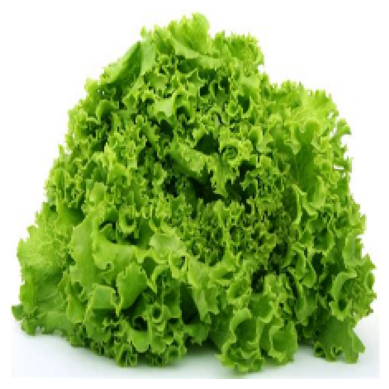

In [ ]:
import matplotlib.pyplot as plt

# ambil 1 batch
for batch_images, batch_labels in train_ds.take(1):
    img_224 = batch_images[0].numpy().astype("uint8")
    plt.imshow(img_224)
    plt.axis("off")
    break


In [ ]:
# Callbacks untuk training efisien
checkpoint_path = '/content/best_lettuce_model.h5'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,  # Save seluruh model
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Training cepat
print("🎯 Starting quick training (8 epochs)...")
history = model.fit(
    train_ds,
    epochs=8,  # Lebih sedikit epoch
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training completed!")

🎯 Starting quick training (8 epochs)...
Epoch 1/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.6831 - loss: 0.7241
Epoch 1: val_accuracy improved from -inf to 0.78125, saving model to /content/best_lettuce_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6903 - loss: 0.7089 - val_accuracy: 0.7812 - val_loss: 0.5422 - learning_rate: 0.0010
Epoch 2/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.9268 - loss: 0.1739
Epoch 2: val_accuracy improved from 0.78125 to 0.79167, saving model to /content/best_lettuce_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 765ms/step - accuracy: 0.9271 - loss: 0.1771 - val_accuracy: 0.7917 - val_loss: 0.5658 - learning_rate: 0.0010
Epoch 3/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9307 - loss: 0.2745
Epoch 3: val_accuracy improved from 0.79167 to 0.81250, saving model to /content/best_lettuce_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 730ms/step - accuracy: 0.9301 - loss: 0.2727 - val_accuracy: 0.8125 - val_loss: 0.3136 - learning_rate: 0.0010
Epoch 4/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9442 - loss: 0.1435
Epoch 4: val_accuracy did not improve from 0.81250
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 750ms/step - accuracy: 0.9448 - loss: 0.1425 - val_accuracy: 0.7917 - val_loss: 0.6867 - learning_rate: 0.0010
Epoch 5/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.9495 - loss: 0.1073
Epoch 5: val_accuracy improved from 0.81250 to 0.91667, saving model to /content/best_lettuce_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 688ms/step - accuracy: 0.9499 - loss: 0.1064 - val_accuracy: 0.9167 - val_loss: 0.3039 - learning_rate: 0.0010
Epoch 6/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9823 - loss: 0.0523
Epoch 6: val_accuracy did not improve from 0.91667
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 645ms/step - accuracy: 0.9814 - loss: 0.0544 - val_accuracy: 0.8750 - val_loss: 0.4951 - learning_rate: 0.0010
Epoch 7/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9720 - loss: 0.0798
Epoch 7: val_accuracy did not improve from 0.91667
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 681ms/step - accuracy: 0.9713 - loss: 0.0814 - val_accuracy: 0.8750 - val_loss: 0.5544 - learning_rate: 0.0010
Epoch 8/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9737 - loss: 0.0924
Epoch 8: val_accuracy improved from 0.91667 to 0.92708, saving model to /content/best_lettuce_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 760ms/step - accuracy: 0.9731 - loss: 0.0925 - val_accuracy: 0.9271 - val_loss: 0.1967 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 8.
✅ Training completed!


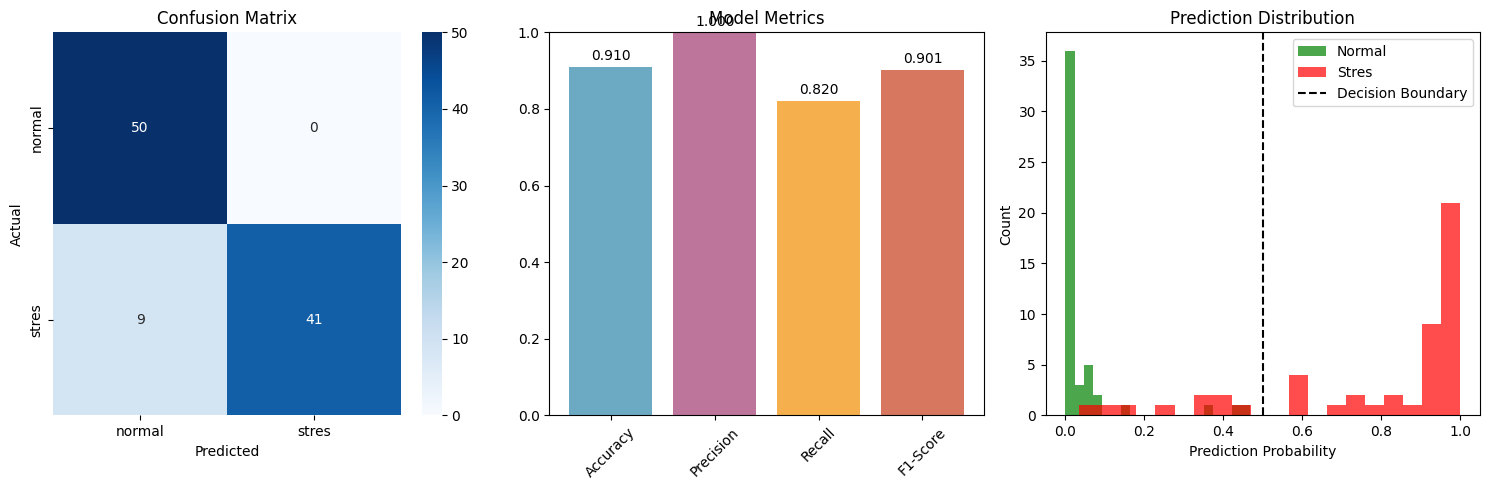

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(15, 5))

# Subplot 1: Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Subplot 2: Metrics Comparison
plt.subplot(1, 3, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [test_accuracy, test_precision, test_recall, f1]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.title('Model Metrics')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

# Subplot 3: Prediction Distribution
plt.subplot(1, 3, 3)
stres_probs = [prob for true, prob in zip(y_true, y_pred_proba) if true == 1]
normal_probs = [prob for true, prob in zip(y_true, y_pred_proba) if true == 0]

plt.hist(normal_probs, bins=20, alpha=0.7, label='Normal', color='green')
plt.hist(stres_probs, bins=20, alpha=0.7, label='Stres', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Decision Boundary')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.title('Prediction Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Final comprehensive evaluation
print("=== FINAL MODEL EVALUATION ===")

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

y_true = []
y_pred_proba = []

print("🔍 Generating predictions...")
for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_proba.extend(preds.flatten())

y_pred = (np.array(y_pred_proba) > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred)
test_recall = recall_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred)

print(f"🎯 TEST SET PERFORMANCE:")
print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")

print("\n📊 CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

print("\n🔢 CONFUSION MATRIX:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Simple text-based visualization
print("\n📈 SIMPLE PERFORMANCE VISUALIZATION:")
print("Accuracy:  " + "█" * int(test_accuracy * 40) + f" {test_accuracy*100:.1f}%")
print("Precision: " + "█" * int(test_precision * 40) + f" {test_precision*100:.1f}%")
print("Recall:    " + "█" * int(test_recall * 40) + f" {test_recall*100:.1f}%")
print("F1-Score:  " + "█" * int(test_f1 * 40) + f" {test_f1*100:.1f}%")

=== FINAL MODEL EVALUATION ===
🔍 Generating predictions...
🎯 TEST SET PERFORMANCE:
Accuracy:  0.9100 (91.00%)
Precision: 1.0000 (100.00%)
Recall:    0.8200 (82.00%)
F1-Score:  0.9011 (90.11%)

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      normal     0.8475    1.0000    0.9174        50
       stres     1.0000    0.8200    0.9011        50

    accuracy                         0.9100       100
   macro avg     0.9237    0.9100    0.9093       100
weighted avg     0.9237    0.9100    0.9093       100


🔢 CONFUSION MATRIX:
[[50  0]
 [ 9 41]]

📈 SIMPLE PERFORMANCE VISUALIZATION:
Accuracy:  ████████████████████████████████████ 91.0%
Precision: ████████████████████████████████████████ 100.0%
Recall:    ████████████████████████████████ 82.0%
F1-Score:  ████████████████████████████████████ 90.1%


In [ ]:
# Save model dengan format yang benar-benar bekerja
print("\n💾 SAVING MODEL (Working Formats Only)...")

# Option 1: Save as Keras format (.keras) - MODERN & RECOMMENDED
keras_format_path = '/content/lettuce_classifier.keras'
best_model.save(keras_format_path)
print(f"✅ Model saved as Keras format: {keras_format_path}")

# Option 2: Save weights only - ALWAYS WORKS
weights_path = '/content/lettuce_classifier.weights.h5'
best_model.save_weights(weights_path)
print(f"✅ Model weights saved: {weights_path}")

# Option 3: Build simple model untuk inference saja
print("\n🔨 Building inference-only model...")

def create_inference_model():
    """Create a clean model for inference only"""
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Simple preprocessing
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    # Base model
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        input_tensor=x,
        weights=None,  # We'll load weights separately
        pooling='avg'
    )

    # Classification head
    x = tf.keras.layers.Dropout(0.3)(base.output)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Create and save clean inference model
inference_model = create_inference_model()
inference_model.load_weights(weights_path)  # Load trained weights

# Save clean model
inference_path = '/content/lettuce_classifier_inference.keras'
inference_model.save(inference_path)
print(f"✅ Clean inference model saved: {inference_path}")

# Verify files
print(f"\n📁 VERIFIED SAVED FILES:")
!ls -la /content/lettuce_classifier* | head -10


💾 SAVING MODEL (Working Formats Only)...
✅ Model saved as Keras format: /content/lettuce_classifier.keras
✅ Model weights saved: /content/lettuce_classifier.weights.h5

🔨 Building inference-only model...
✅ Clean inference model saved: /content/lettuce_classifier_inference.keras

📁 VERIFIED SAVED FILES:
-rw-r--r-- 1 root root      800 Nov 15 04:41 /content/lettuce_classifier_final.h5
-rw-r--r-- 1 root root 17039949 Nov 15 04:46 /content/lettuce_classifier_inference.keras
-rw-r--r-- 1 root root 17074891 Nov 15 04:46 /content/lettuce_classifier.keras
-rw-r--r-- 1 root root      800 Nov 15 04:45 /content/lettuce_classifier_model.h5
-rw-r--r-- 1 root root 16858952 Nov 15 04:46 /content/lettuce_classifier.weights.h5


In [ ]:
# Backup model ke Google Drive untuk penyimpanan permanen
from google.colab import drive

try:
    drive.mount('/content/drive')

    # Copy model files to Drive
    import shutil

    drive_backup_dir = '/content/drive/MyDrive/lettuce_classifier'
    Path(drive_backup_dir).mkdir(exist_ok=True)

    model_files = list(Path('/content').glob('lettuce_classifier*'))
    for file_path in model_files:
        if file_path.is_file():
            shutil.copy2(file_path, drive_backup_dir)

    print(f"✅ Model backed up to: {drive_backup_dir}")
    print(f"📁 Files backed up: {len(list(Path(drive_backup_dir).glob('*')))}")

except Exception as e:
    print(f"⚠️ Drive backup skipped: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model backed up to: /content/drive/MyDrive/lettuce_classifier
📁 Files backed up: 5


In [ ]:
# Convert to TensorFlow Lite for Flutter
print("🔄 Converting to TensorFlow Lite...")

# Load the best model
final_model = tf.keras.models.load_model('/content/lettuce_classifier.keras')

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

# Optimize for mobile
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Optional: Untuk ukuran lebih kecil, gunakan quantization
converter.target_spec.supported_types = [tf.float16]

try:
    tflite_model = converter.convert()

    # Save TFLite model
    tflite_path = '/content/lettuce_classifier.tflite'
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    print(f"✅ TensorFlow Lite model saved: {tflite_path}")
    print(f"📦 Model size: {len(tflite_model) / 1024 / 1024:.2f} MB")

except Exception as e:
    print(f"❌ TFLite conversion failed: {e}")
    print("🔄 Trying without optimization...")

    # Fallback: Convert without optimization
    converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
    tflite_model = converter.convert()

    tflite_path = '/content/lettuce_classifier.tflite'
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    print(f"✅ TensorFlow Lite model saved (no optimization): {tflite_path}")
    print(f"📦 Model size: {len(tflite_model) / 1024 / 1024:.2f} MB")

🔄 Converting to TensorFlow Lite...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 432 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmprjiqm30u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134977471397712: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134977471382544: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134978935862096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134977477002256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134977477002064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134978612850384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134979771208080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134977477001488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134977477003216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134977477003024: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [ ]:
from google.colab import files
import zipfile
from pathlib import Path

# Buat zip file berisi semua file model untuk Flutter
print("📦 Creating download package...")

# File-file yang akan didownload
flutter_files = [
    '/content/lettuce_classifier.tflite',
    '/content/lettuce_classifier.keras',
    '/content/lettuce_classifier.weights.h5',
    '/content/model_metadata.json',
    '/content/flutter_integration_guide.md'
]

# Buat zip file
zip_path = '/content/lettuce_classifier_flutter_package.zip'
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for file_path in flutter_files:
        if Path(file_path).exists():
            zipf.write(file_path, Path(file_path).name)
            print(f"✅ Added: {Path(file_path).name}")

print(f"📦 Zip file created: {zip_path}")
print(f"📊 Zip size: {Path(zip_path).stat().st_size / 1024 / 1024:.2f} MB")

# Download zip file
print("\n⬇️  Downloading zip file to your computer...")
files.download(zip_path)

📦 Creating download package...
✅ Added: lettuce_classifier.tflite
✅ Added: lettuce_classifier.keras
✅ Added: lettuce_classifier.weights.h5
📦 Zip file created: /content/lettuce_classifier_flutter_package.zip
📊 Zip size: 40.06 MB

⬇️  Downloading zip file to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Download semua file lettuce classifier yang ada
files_to_download = [
    'lettuce_classifier.keras',
    'lettuce_classifier.tflite',
    'lettuce_classifier.weights.h5',  # Ini pengganti lettuce_classifier_weights.h5
    'best_lettuce_model.h5',
    'lettuce_classifier_final.h5',
    'lettuce_classifier_model.h5',
    'lettuce_classifier_inference.keras',
    'lettuce_classifier_flutter_package.zip'
]

for file in files_to_download:
    try:
        print(f"📥 Downloading {file}...")
        files.download(file)
        print(f"✅ {file} berhasil didownload")
    except Exception as e:
        print(f"❌ Gagal download {file}: {e}")

📥 Downloading lettuce_classifier.keras...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ lettuce_classifier.keras berhasil didownload
📥 Downloading lettuce_classifier.tflite...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ lettuce_classifier.tflite berhasil didownload
📥 Downloading lettuce_classifier.weights.h5...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ lettuce_classifier.weights.h5 berhasil didownload
📥 Downloading best_lettuce_model.h5...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ best_lettuce_model.h5 berhasil didownload
📥 Downloading lettuce_classifier_final.h5...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ lettuce_classifier_final.h5 berhasil didownload
📥 Downloading lettuce_classifier_model.h5...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ lettuce_classifier_model.h5 berhasil didownload
📥 Downloading lettuce_classifier_inference.keras...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ lettuce_classifier_inference.keras berhasil didownload
📥 Downloading lettuce_classifier_flutter_package.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ lettuce_classifier_flutter_package.zip berhasil didownload


In [ ]:
import zipfile
import os
from google.colab import files

# HANYA file model penting saja
important_files = [
    'lettuce_classifier.keras',
    'lettuce_classifier.tflite',
    'lettuce_classifier.weights.h5',
    'best_lettuce_model.h5',
    'lettuce_classifier_final.h5',
    'lettuce_classifier_model.h5',
    'lettuce_classifier_inference.keras'
]

# Filter hanya file yang benar-benar ada
existing_files = [f for f in important_files if os.path.exists(f)]

print("📦 Membuat ZIP baru hanya dengan file penting...")
zip_filename = 'lettuce_classifier_ESSENTIAL.zip'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in existing_files:
        size_mb = os.path.getsize(file) / (1024 * 1024)
        zipf.write(file)
        print(f"✅ {file} - {size_mb:.1f} MB")

# Cek ukuran baru
new_size_mb = os.path.getsize(zip_filename) / (1024 * 1024)
print(f"🎯 Ukuran ZIP baru: {new_size_mb:.1f} MB (seharusnya < 500 MB)")

# Download yang baru
files.download(zip_filename)
print("📥 Downloading ZIP essentials...")

📦 Membuat ZIP baru hanya dengan file penting...
✅ lettuce_classifier.keras - 16.3 MB
✅ lettuce_classifier.tflite - 7.7 MB
✅ lettuce_classifier.weights.h5 - 16.1 MB
✅ best_lettuce_model.h5 - 47.0 MB
✅ lettuce_classifier_final.h5 - 0.0 MB
✅ lettuce_classifier_model.h5 - 0.0 MB
✅ lettuce_classifier_inference.keras - 16.3 MB
🎯 Ukuran ZIP baru: 103.3 MB (seharusnya < 500 MB)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloading ZIP essentials...


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Simpan ke Google Drive
files_to_save = [
    'best_lettuce_model.h5',
    'lettuce_classifier.keras',
    'lettuce_classifier.tflite',
    'lettuce_classifier.weights.h5'
]

print("💾 Menyimpan ke Google Drive...")
for file in files_to_save:
    drive_path = f'/content/drive/MyDrive/{file}'
    shutil.copy(file, drive_path)
    print(f"✅ {file} → Google Drive")

print("🎉 FILE SUDAH DI GOOGLE DRIVE!")
print("🌐 Buka: drive.google.com")
print("📁 Cari file di folder 'MyDrive'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
💾 Menyimpan ke Google Drive...
✅ best_lettuce_model.h5 → Google Drive
✅ lettuce_classifier.keras → Google Drive
✅ lettuce_classifier.tflite → Google Drive
✅ lettuce_classifier.weights.h5 → Google Drive
🎉 FILE SUDAH DI GOOGLE DRIVE!
🌐 Buka: drive.google.com
📁 Cari file di folder 'MyDrive'


In [ ]:
from google.colab import files

print("📥 Download file penting satu per satu...")

# Download yang paling penting dulu
important_files = [
    'lettuce_classifier.tflite',  # Untuk mobile apps
    'lettuce_classifier.keras',   # Model utama
    'lettuce_classifier.weights.h5' # Weights
]

for file in important_files:
    print(f"Mendownload {file}...")
    files.download(file)
    input("⏳ Tekan Enter setelah download selesai, lalu lanjut ke file berikutnya...")

📥 Download file penting satu per satu...
Mendownload lettuce_classifier.tflite...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⏳ Tekan Enter setelah download selesai, lalu lanjut ke file berikutnya...
Mendownload lettuce_classifier.keras...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⏳ Tekan Enter setelah download selesai, lalu lanjut ke file berikutnya...
Mendownload lettuce_classifier.weights.h5...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⏳ Tekan Enter setelah download selesai, lalu lanjut ke file berikutnya...
